## 基本概率论

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l
from torch.distributions import multinomial

### 概率基础：从扔硬币到掷骰子

#### 1. 伯努利试验 (Bernoulli Trial)

想象一下我们扔一次硬币，结果只可能是“正面”或“反面”。这种只有两种可能结果，且每次试验都相互独立的随机试验，就叫做**伯努利试验**。

*   **结果**: 成功 (通常记为1) 或 失败 (记为0)。
*   **概率**: 成功的概率为 $p$，则失败的概率为 $1-p$。

#### 2. 分类分布 (Categorical Distribution)

现在，我们不扔硬幣，而是掷一个六面的骰子。结果有6种可能：{1, 2, 3, 4, 5, 6}。

**分类分布**就是伯努利分布的泛化，它描述的是**单次试验**下，结果有 $k$ 个可能类别的概率分布。对于一个标准的、公平的六面骰子：

*   **类别数**: $k = 6$
*   **每次试验次数**: 1次
*   **每个类别的概率**: $P(\text{结果}=i) = p_i$。对于公平骰子，$p_1 = p_2 = ... = p_6 = \frac{1}{6}$。
*   **概率约束**: 所有类别的概率之和必须为1，即 $\sum_{i=1}^{k} p_i = 1$。

> **核心思想**: 分类分布是**掷一次多面骰子**的数学模型。

#### 3. 多项分布 (Multinomial Distribution)

如果我们不只掷一次骰子，而是掷 $n$ 次呢？比如，我们把一个公平的六面骰子掷10次，我们可能关心的不是某一次的结果，而是最终“点数1”出现了几次，“点数2”出现了几次，...，“点数6”出现了几次。

**多项分布**描述的就是这样的场景。它是分类分布的泛化，描述了在 $n$ 次独立试验中，每种类别结果出现的**次数**的概率分布。

它的数学定义如下：

假设一个随机试验有 $k$ 个互斥的结果，它们的概率分别是 $p_1, p_2, ..., p_k$，且 $\sum_{i=1}^{k} p_i = 1$。现在我们独立地重复这个试验 $n$ 次。

我们用随机变量 $X_i$ 表示第 $i$ 种结果在 $n$ 次试验中出现的次数。那么，向量 $X = (X_1, X_2, ..., X_k)$ 服从多项分布。其概率质量函数 (PMF) 为：

$$
P(X_1=x_1, X_2=x_2, ..., X_k=x_k) = \frac{n!}{x_1! x_2! ... x_k!} p_1^{x_1} p_2^{x_2} ... p_k^{x_k}
$$

其中，$\sum_{i=1}^{k} x_i = n$，即所有结果出现的次数加起来必然等于总试验次数 $n$。

> **核心思想**: 多项分布是**掷 n 次多面骰子，统计每个面出现次数**的数学模型。

**一个重要的特例**: 当试验总次数 $n=1$ 时，多项分布就退化为了分类分布。因为只做一次试验，结果必然是某一个类别出现1次，其他所有类别都出现0次。

In [2]:

# 1. 定义概率分布
# torch.ones([6]) 创建一个包含6个1的张量：tensor([1., 1., 1., 1., 1., 1.])
# 除以 6 将其归一化，得到每个类别的概率都是 1/6
# 这精确地模拟了一个公平的六面骰子
fair_probs = torch.ones([6]) / 6
# fair_probs 的值是: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

# 2. 创建一个多项分布对象
# 第一个参数 total_count=1，对应多项分布公式中的 n，表示我们只进行1次试验。
# 第二个参数 probs=fair_probs，对应公式中的 p，是我们定义的概率向量。
# 因为 n=1，这实际上是一个分类分布。
dist = multinomial.Multinomial(1, fair_probs)

In [3]:
fair_probs,dist

(tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]), Multinomial())

In [7]:
dist.sample() #每次都不一样的

tensor([0., 0., 0., 0., 1., 0.])

In [8]:
multinomial.Multinomial(10, fair_probs).sample()

tensor([2., 0., 1., 0., 5., 2.])

In [9]:
counts = multinomial.Multinomial(1000, fair_probs).sample()

In [10]:
counts

tensor([184., 149., 163., 161., 182., 161.])

In [11]:
counts/1000

tensor([0.1840, 0.1490, 0.1630, 0.1610, 0.1820, 0.1610])

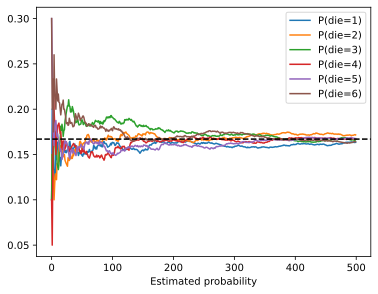

In [14]:
#我们也可以看到这些概率如何随着时间的推移收敛到真实概率。让我们进行500组实验，每组抽取10个样本。
counts = multinomial.Multinomial(10,fair_probs).sample((500,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts/cum_counts.sum(dim=1,keepdim=True)
d2l.set_figsize((6,4.5))
for i in range(6):
    d2l.plt.plot(estimates[:,i].numpy(),label="P(die="+str(i+1)+")")
d2l.plt.axhline(y=0.167,color='black',linestyle='dashed')
d2l.plt.gca().set_xlabel("Group of experiments")
d2l.plt.gca().set_xlabel("Estimated probability")
d2l.plt.legend()

## 概率论公理
概率 (probability) 可以被认为是将集合映射到真实值的函数。在给定的样本空间$S$中，事件$A$的概率，表示为$P(A)$，满足以下属性：

*   对于任意事件$A$，其概率从不会是负数，即$P(A) \ge 0$；

*   整个样本空间的概率为1，即$P(S) = 1$；

*   对于互斥 (mutually exclusive) 事件（对于所有$i \neq j$都有$A_i \cap A_j = \emptyset$）的任意一个可数序列$A_1, A_2, \dots,$ 序列中任意一个事件发生的概率等于它们各自发生的概率之和，即 $P(\bigcup_{i=1}^{\infty} A_i) = \sum_{i=1}^{\infty} P(A_i)$。

以上也是概率论的公理，由科尔莫戈罗夫于1933年提出。有了这个公理系统，我们可以避免任何关于随机性的哲学争论；相反，我们可以用数学语言严格地推理。例如，假设事件$A_1$为整个样本空间，且当所有$i_1$时$A_i = \emptyset$，那么我们可以证明$P(\emptyset) = 0$，即不可能发生事件的概率是0。

### 联合概率

第一个被称为联合概率 (joint probability) $P(A = a, B = b)$。给定任意值$a$和$b$，联合概率可以回答：$A=a$和$B=b$同时满足的概率是多少？请注意，对于任何$a$和$b$的取值，$P(A = a, B = b) \le P(A = a)$。这点是确定的，因为要同时发生$A=a$和$B=b$，$A=a$就必须发生，$B=b$也必须发生（反之亦然）。因此，$A=a$和$B=b$同时发生的可能性不大于$A=a$或是$B=b$单独发生的可能性。

### 条件概率

联合概率的不等式带给我们一个有趣的比率：$0 \le \frac{P(A=a, B=b)}{P(A=a)} \le 1$。我们称这个比率为条件概率 (conditional probability)，并用$P(B = b | A = a)$表示它：它是$B=b$的概率，前提是$A=a$已发生。

### 贝叶斯定理

使用条件概率的定义，我们可以得出统计学中最有用的方程之一：Bayes定理 (Bayes' theorem)。根据乘法法则 (multiplication rule) 可得到$P(A,B) = P(B|A)P(A)$。根据对称性，可得到$P(A,B) = P(A|B)P(B)$。假设$P(B) > 0$，求解其中一个条件变量，我们得到

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

请注意，这里我们使用紧凑的表示法：其中$P(A,B)$是一个联合分布 (joint distribution)，$P(A|B)$是一个条件分布 (conditional distribution)。这种分布可以在给定值$A=a, B=b$上进行求值。

### 边际化

为了能进行事件概率求和，我们需要求和法则 (sum rule)，即$B$的概率相当于计算$A$的所有可能选择，并将所有选择的联合概率聚合在一起：

$$
P(B) = \sum_{A} P(A,B),
$$

这也称为边际化 (marginalization)。边际化结果的概率或分布称为边际概率 (marginal probability) 或边际分布 (marginal distribution)。
### 期望和方差
为了概括概率分布的关键特征，我们需要一些测量方法。一个随机变量X的期望 (expectation, 或平均值 (average)) 表示为

$$
E[X] = \sum_{x} xP(X=x).
$$

当函数$f(x)$的输入是从分布P中抽取的随机变量时，$f(x)$的期望值为

$$
E_{x \sim P}[f(x)] = \sum_{x} f(x)P(x).
$$

在许多情况下，我们希望衡量随机变量X与其期望值的偏置。这可以通过方差来量化

$$
\mathrm{Var}[X] = E\left[(X - E[X])^2\right] = E[X^2] - E[X]^2.
$$

方差的平方根被称为标准差 (standard deviation)。随机变量函数的方差衡量的是：当从该随机变量分布中采样不同值$x$时，函数值偏离该函数的期望的程度：

$$
\mathrm{Var}[f(x)] = E\left[(f(x) - E[f(x)])^2\right].
$$

# 练习
1. 进行$m=500$ 组实验,每组抽取$n=10$个样本。改变$m$和$n$,观察和分析实验结果

In [17]:
import torch
from torch.distributions import multinomial
from d2l import torch as d2l # 使用d2l库进行绘图
d2l.plt.rcParams['font.sans-serif']=['SimHei'] #解决中文显示
d2l.plt.rcParams['axes.unicode_minus'] = False #解决符号无法显示
def simulate_and_plot_convergence(num_experiments, samples_per_experiment, true_probs):
    """
    模拟多项分布实验并绘制概率收敛图。

    参数:
    - num_experiments (int): 实验组数 (m)。
    - samples_per_experiment (int): 每组实验的样本数 (n)。
    - true_probs (torch.Tensor): 各事件的真实概率分布。
    """
    print(f"开始模拟: {num_experiments} 组实验, 每组 {samples_per_experiment} 个样本。")
    print(f"总样本数: {num_experiments * samples_per_experiment}")
    
    # 1. 定义多项分布并采样
    # total_count 现在由 `samples_per_experiment` (n) 控制
    # .sample((num_experiments,)) 由 `num_experiments` (m) 控制
    distribution = multinomial.Multinomial(samples_per_experiment, true_probs)
    counts = distribution.sample((num_experiments,))
    
    # 2. 计算累积计数和估计概率
    cum_counts = counts.cumsum(dim=0)
    total_samples_so_far = cum_counts.sum(dim=1, keepdim=True)
    estimates = cum_counts / total_samples_so_far
    
    # 3. 绘图
    num_outcomes = true_probs.shape[0]
    d2l.set_figsize((8, 6)) # 调整画布大小
    
    # 绘制每个结果的估计概率收敛曲线
    for i in range(num_outcomes):
        d2l.plt.plot(estimates[:, i].numpy(), label=f"P(结果 {i+1})")
        
    # 绘制真实概率参考线
    # 这里我们只为第一个结果绘制参考线，以简化图形
    d2l.plt.axhline(y=true_probs[0].item(), color='black', linestyle='dashed', label="真实概率")
    
    # 设置图表标题和标签
    title = (f"m={num_experiments}, n={samples_per_experiment}\n"
             f"总样本数 = {num_experiments * samples_per_experiment}")
    d2l.plt.gca().set_title(title)
    d2l.plt.gca().set_xlabel("实验组数")
    d2l.plt.gca().set_ylabel("估计概率")
    d2l.plt.legend()
    d2l.plt.show()

# 定义公平骰子的真实概率
fair_probs = torch.ones(6) / 6

开始模拟: 500 组实验, 每组 10 个样本。
总样本数: 5000


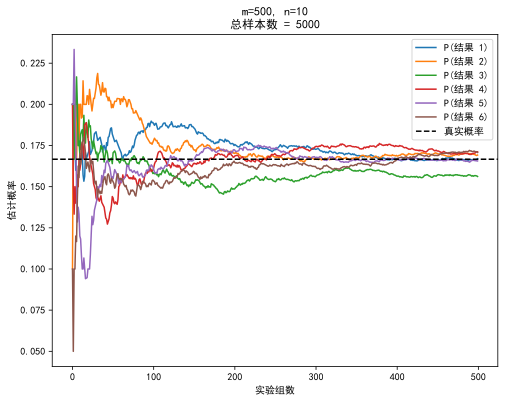

In [18]:
# 原始设置
m_orig, n_orig = 500, 10
simulate_and_plot_convergence(m_orig, n_orig, fair_probs)

开始模拟: 500 组实验, 每组 100 个样本。
总样本数: 50000


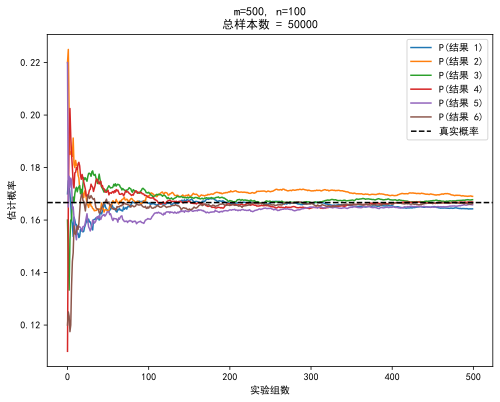

In [19]:
# 增加 n
m_high_n, n_high_n = 500, 100
simulate_and_plot_convergence(m_high_n, n_high_n, fair_probs)
#增加 n 可以降低单次实验结果的方差，使得概率估计的收敛过程更加平滑和迅速。

开始模拟: 5000 组实验, 每组 10 个样本。
总样本数: 50000


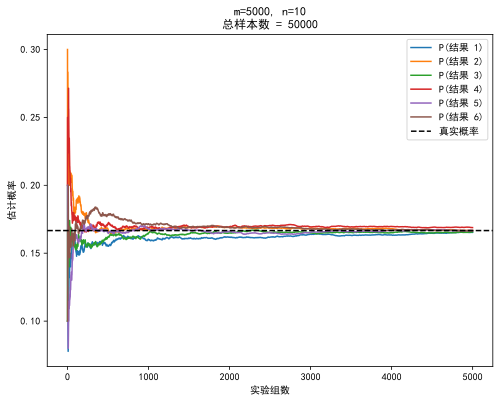

In [20]:
#增加组数
m_high_m, n_high_m = 5000, 10
simulate_and_plot_convergence(m_high_m, n_high_m, fair_probs)

开始模拟: 50 组实验, 每组 5 个样本。
总样本数: 250


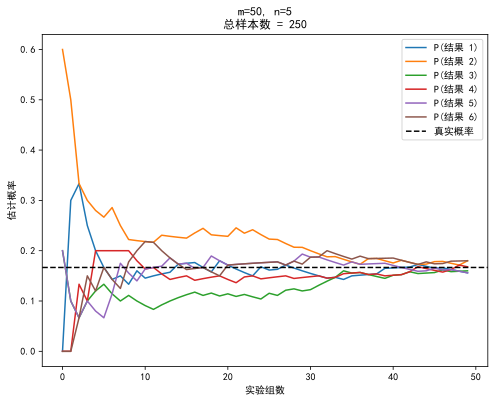

In [21]:
# m 和 n 都很小
m_low, n_low = 50, 5
simulate_and_plot_convergence(m_low, n_low, fair_probs)

过对参数 $m$ 和 $n$ 的探索，我们可以得出以下深刻的理解：

*   **每组样本数 $n$**：决定了**单次实验的可靠性**。越大的 $n$ 意味着单次实验的结果（即`counts`中的一行）方差越小，因此我们绘制的估计概率曲线从一开始就更平滑、更接近真实值。

*   **实验组数 $m$**：决定了我们**观察收敛过程的“时间”长度**。越大的 $m$ 让我们能够通过更多次的独立重复来验证长期趋势，最终观察到无论初始波动多大，曲线终将收敛。

*   **总样本数 $N_{total} = m \times n$**：这是**大数定律发挥作用的根本**。无论是通过增加 $n$ 还是 $m$，只要总样本数 $N_{total}$ 足够大，经验概率就会是对真实概率的良好近似。场景二和场景三具有相同的总样本数（50,000），因此它们最终的收敛精度是相似的，但达到该精度的“路径”或“轨迹”有所不同。


2：**给定两个事件 $A$ 和 $B$ 以及它们的概率 $P(A)$ 和 $P(B)$，计算 $P(A \cup B)$（并集）和 $P(A \cap B)$（交集）的上限和下限。**

我们将使用基本的概率公理和韦恩图（Venn Diagram）的直观思想来推导这些界限。核心的公式是概率的加法法则：

$$
P(A \cup B) = P(A) + P(B) - P(A \cap B)
$$

我们可以通过调整交集 $P(A \cap B)$ 的大小来找到并集 $P(A \cup B)$ 的界限，反之亦然。

#### 1. 交集 $P(A \cap B)$ 的界限

交集代表事件 A 和 B *共同发生*的概率。

*   **上限 (Upper Bound):**
    一个事件与另一个事件的交集，最大也不可能超过任何一个事件本身。想象一下韦恩图，两个圆圈重叠的部分，面积不可能比任何一个单独的圆圈还大。
    因此，交集的概率必须小于或等于两个事件概率中的较小者。

    $$
    P(A \cap B) \le \min(P(A), P(B))
    $$

    *   **直观情况**: 当一个事件完全包含另一个事件时（例如，B 是 A 的子集），达到上限。此时 $A \cap B = B$，所以 $P(A \cap B) = P(B)$（假设 $P(B) \le P(A)$）。

*   **下限 (Lower Bound):**
    为了找到交集的下限，我们重新整理加法法则：$P(A \cap B) = P(A) + P(B) - P(A \cup B)$。要使 $P(A \cap B)$ 最小，我们需要让 $P(A \cup B)$ 最大。
    任何事件的概率最大为 1，所以 $P(A \cup B)$ 的最大值是 1。
    
    $$
    P(A \cap B) \ge P(A) + P(B) - 1
    $$

    同时，概率不能是负数，所以 $P(A \cap B) \ge 0$。我们需要取这两者中更严格（即更大）的那个作为下限。

    $$
    P(A \cap B) \ge \max(0, P(A) + P(B) - 1)
    $$
    
    *   **直观情况**: 当 $P(A) + P(B) \le 1$ 时，A 和 B 可以是互斥事件（不重叠），此时下限为 0。当 $P(A) + P(B) > 1$ 时，它们必须有重叠，最少重叠的部分就是 $P(A) + P(B) - 1$。

#### 2. 并集 $P(A \cup B)$ 的界限

并集代表事件 A 或 B *至少一个发生*的概率。

*   **上限 (Upper Bound):**
    同样，我们使用加法法则 $P(A \cup B) = P(A) + P(B) - P(A \cap B)$。为了让 $P(A \cup B)$ 最大，我们需要让 $P(A \cap B)$ 最小。
    从上面我们知道 $P(A \cap B)$ 的下限是 $\max(0, P(A) + P(B) - 1)$。
    所以，并集的上限是 $P(A) + P(B) - \max(0, P(A) + P(B) - 1)$。
    这可以简化为：
    
    $$
    P(A \cup B) \le \min(1, P(A) + P(B))
    $$

    *   **直观情况**: 如果 $A$ 和 $B$ 可以互斥（$P(A)+P(B) \le 1$），则并集最大就是它们概率的和。如果它们概率的和超过1，则并集的最大值被限制为1。

*   **下限 (Lower Bound):**
    为了让 $P(A \cup B)$ 最小，我们需要让交集 $P(A \cap B)$ 最大化。
    从上面我们知道 $P(A \cap B)$ 的上限是 $\min(P(A), P(B))$。
    
    $$
    P(A \cup B) \ge P(A) + P(B) - \min(P(A), P(B))
    $$

    这个表达式可以简化为 $P(A)$ 和 $P(B)$ 中的较大值。
    
    $$
    P(A \cup B) \ge \max(P(A), P(B))
    $$

    *   **直观情况**: 并集事件包含了 A 和 B 两个事件，所以其概率至少要等于两个事件中概率较大的那个。这个下限在一个事件完全包含另一个事件时达到。

#### **总结**

| 概率 | 下限 (Lower Bound) | 上限 (Upper Bound) |
| :--- | :--- | :--- |
| **$P(A \cap B)$** | $\max(0, P(A) + P(B) - 1)$ | $\min(P(A), P(B))$ |
| **$P(A \cup B)$** | $\max(P(A), P(B))$ | $\min(1, P(A) + P(B))$ |

---

3：**假设我们有一系列随机变量 A, B, C，其中 B 只依赖于 A，而 C 只依赖于 B。我们能否简化联合概率 $P(A, B, C)$？**

答案是**可以的**，这正是**马尔可夫链 (Markov Chain)** 的核心性质。

#### 1. 从链式法则开始

对于任何三个随机变量 A, B, C，它们的联合概率可以通过链式法则（Chain Rule of Probability）分解：

$$
P(A, B, C) = P(A) \cdot P(B | A) \cdot P(C | A, B)
$$

这个法则是永远成立的。它的意思是：“A, B, C 同时发生的概率”等于“A 发生的概率”乘以“在 A 发生的条件下 B 发生的概率”再乘以“在 A 和 B 都发生的条件下 C 发生的概率”。

#### 2. 应用马尔可夫性质

题目给出了关键的依赖关系，我们可以将其翻译成条件概率的语言：

1.  **"B 只依赖于 A"**: 这已经体现在链式法则的第二项 $P(B|A)$ 中了。
2.  **"C 只依赖于 B"**: 这是关键的简化步骤。这个陈述意味着，一旦我们知道了 B 的状态，关于 A 的任何信息对于预测 C 都是多余的。这在数学上被称为**条件独立 (Conditional Independence)**。我们说，给定 B，C 与 A 是条件独立的。

用公式表达就是：

$$
P(C | A, B) = P(C | B)
$$

这个等式就是马尔可夫性质的数学体现。它表示从 A 到 B 再到 C 的依赖链条中，C 的“记忆”只延伸到 B，而不会再往前追溯到 A。

#### 3. 简化联合概率

现在，我们将这个简化的条件概率 $P(C | B)$ 代入原始的链式法则中：

$$
P(A, B, C) = P(A) \cdot P(B | A) \cdot P(C | B)
$$

这就是简化后的联合概率表达式。

#### **直观理解**

我们可以将 $A \to B \to C$ 看作一个时间序列或一个因果链条：
*   $A$：昨天的天气
*   $B$：今天的天气
*   $C$：明天的天气

马尔可夫假设认为，**明天的天气 ($C$) 只取决于今天的天气 ($B$)，而与昨天的天气 ($A$) 无关**（在已知今天天气的情况下）。因此，要计算昨天、今天、明天分别是晴、雨、晴的概率，你只需要：
*   昨天是晴天的概率：$P(A=\text{晴})$
*   昨天晴天的情况下，今天是雨天的转移概率：$P(B=\text{雨} | A=\text{晴})$
*   今天雨天的情况下，明天是晴天的转移概率：$P(C=\text{晴} | B=\text{雨})$

三者相乘，就是这个特定天气序列的联合概率。这个结构在自然语言处理（如n-gram模型）、强化学习（马尔可夫决策过程）和许多其他领域都有着基础性的应用。

4.在2.6.2节中，第一个测试更准确。为什么不运行第一个测试两次，而是同时运行第一个和第二个测试?
在提供的材料中，计算的核心基于一个关键假设：**两个测试在给定患者真实健康状况（$H$）的条件下是独立的**。

我们来分析两种情况下的概率计算。

#### 情况一：运行测试1和测试2 (材料中的做法)

材料中假设了**条件独立性**：当一个人的真实情况确定后（比如他确实有病, $H=1$），测试1的结果和测试2的结果是相互独立的。这在数学上表示为：

$$
P(D_1=1, D_2=1 | H=1) = P(D_1=1 | H=1) \times P(D_2=1 | H=1)
$$
$$
P(D_1=1, D_2=1 | H=0) = P(D_1=1 | H=0) \times P(D_2=1 | H=0)
$$

这个假设是合理的，因为两个测试通常基于不同的生物学原理或化学试剂。一个测试可能因为患者体内某种特定的干扰物质而产生假阳性，但另一个完全不同的测试不太可能因为**同一种物质**产生同样的假阳性。

根据材料中的数据：
*   $P(D_1=1 | H=0) = 0.01$ (测试1的假阳性率)
*   $P(D_2=1 | H=0) = 0.03$ (测试2的假阳性率)

两个测试都呈假阳性的概率是 $0.01 \times 0.03 = 0.0003$，这是一个非常小的数字。正是因为这个概率极低，当两个测试都呈阳性时，我们就有很强的信心认为这个人是真的有病（$H=1$）。最终计算出的后验概率也因此从第一次测试后的13.06%飙升到了83.07%。

#### 情况二：运行两次测试1 (我们假设的做法)

现在，让我们考虑一下，如果我们将第一个测试运行两次，结果会怎样。我们用 $D_{1a}$ 和 $D_{1b}$ 表示测试1的第一次和第二次结果。

最大的问题是，**$D_{1a}$ 和 $D_{1b}$ 很可能不是条件独立的**。

为什么呢？如果一个健康人（$H=0$）在第一次测试中得到了一个阳性结果（$D_{1a}=1$），这通常不是一个完全随机的事件。其背后很可能有一个**系统性的原因**，例如：
*   该患者血液中有某种抗体，恰好能与测试1的试剂发生交叉反应。
*   测试1所用的那批试剂本身存在质量问题。
*   操作人员在处理该样本时有固定的错误习惯。

如果存在这些系统性原因，那么当你用**同样的测试方法**对**同一样本**进行第二次检测时，极有可能再次触发同样的问题！

在这种情况下，一个健康人第一次测出假阳性后，第二次也测出假阳性的概率就远不是 $0.01$ 了。即：
$$
P(D_{1b}=1 | D_{1a}=1, H=0) \gg P(D_{1b}=1 | H=0)
$$
在极端情况下，如果假阳性完全是由患者体内的某种稳定物质引起的，那么这个概率 $P(D_{1b}=1 | D_{1a}=1, H=0)$ 可能接近于 1！

如果我们用这个（更现实的）依赖性来计算，会发生什么？
我们沿用贝叶斯公式来计算两次测试1都为阳性后，患者有病的概率 $P(H=1 | D_{1a}=1, D_{1b}=1)$：

$$
P(H=1 | D_{1a}=1, D_{1b}=1) = \frac{P(D_{1a}=1, D_{1b}=1 | H=1)P(H=1)}{P(D_{1a}=1, D_{1b}=1)}
$$

我们来分析分母中的 $P(D_{1a}=1, D_{1b}=1 | H=0)$：
$$
P(D_{1a}=1, D_{1b}=1 | H=0) = P(D_{1b}=1 | D_{1a}=1, H=0) \times P(D_{1a}=1 | H=0)
$$
如果我们假设 $P(D_{1b}=1 | D_{1a}=1, H=0) \approx 1$ (因为系统性错误)，那么：
$$
P(D_{1a}=1, D_{1b}=1 | H=0) \approx 1 \times 0.01 = 0.01
$$
你看，这个结果和**只做一次测试1的假阳性概率是一样的！**

这意味着，第二次运行同样的测试几乎没有提供任何关于排除假阳性的新信息。最终计算出的后验概率 $P(H=1 | D_{1a}=1, D_{1b}=1)$ 将会非常接近于第一次测试后的 $13.06\%$，几乎没有提升。